In [1]:
# Initial imports and environment setting.

%matplotlib inline
import numpy as np
import pandas as pd
from textwrap import wrap

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})

import seaborn as sns
sns.set(context='talk', style='white')

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load in the data. This spreadsheet is (almost) direct from SurveyMonkey,
# though IP addresses and access dates were scrubbed to anonymize.

df = pd.read_csv('aperture_survey_responses.tsv', sep='\t')

In [3]:
# SurveyMonkey provides an odd nesting of responses when exporting results.
# We'd like to convert this structure to a pandas MultiIndex data frame.
# First, let's find question indices -- adapted from https://stackoverflow.com/a/49584888

indices = [i for i, c in enumerate(df.columns) if not c.startswith('Unnamed')]
slices = [slice(i, j) for i, j in zip(indices, indices[1:] + [None])]
repeats = [len(range(*slice.indices(len(df.columns)))) for slice in slices]

In [4]:
# Now let's grab all of the questions and each of the options provided as possible responses.

questions = [c for c in df.columns if not c.startswith('Unnamed')]
options = df.iloc[:1].values[0].tolist()

# We can pair each possible response with its associated question...

matched_questions = []
for index, question in enumerate(questions):
    matched_questions += [question] * repeats[index]

# ...and create a new dataframe named 'responses' that correctly pairs questions and responses.

index = pd.MultiIndex.from_arrays([matched_questions, options],
                                  names=('question', 'options'))
data = df.iloc[2:].values
responses = pd.DataFrame(data=data, columns=index)

In [5]:
# Optional data cleaning -- remove 'Other' responses for easier plotting.

responses.drop('Other', axis=1, level=1, inplace=True)

In [6]:
# First question of interest -- the normalize keyword converts to percentages.
responses['Should OHBM have an official publishing platform?',
          'Response'].value_counts(normalize=True)

Yes    0.865591
No     0.134409
Name: (Should OHBM have an official publishing platform?, Response), dtype: float64

In [7]:
def plot_stacked_bar(df, figwidth=12.5, textwrap=30):
    """
    A wrapper function to create a stacked bar plot.
    Seaborn does not implement this directly, so
    we'll use seaborn styling in matplotlib.
    
    Inputs
    ------
    
    figwidth: float
        The desired width of the figure. Also controls
        spacing between bars.
    
    textwrap: int
        The number of characters (including spaces) allowed
        on a line before wrapping to a newline.
    """
    reshape = pd.melt(df, var_name='option', value_name='rating')
    stack = reshape.rename_axis('count').reset_index().groupby(['option', 'rating']).count().reset_index()

    fig, ax = plt.subplots(1, 1, figsize=(15, figwidth))
    bottom = np.zeros(len(stack['option'].unique()))
    clrs = sns.color_palette('Set1', n_colors=5)  # to do: check colorblind friendly-ness
    labels = ['Strongly agree', 'Agree', 'Neither agree nor disagree', 'Disagree', 'Strongly disagree']
    
    for rating in range(1, 6):
        stackd = stack.query(f'rating == {rating}')
        ax.barh(y=stackd['option'], width=stackd['count'], left=bottom,
                tick_label=['\n'.join(wrap(s, textwrap)) for s in stackd['option']],
                color=clrs[rating - 1], label=labels[rating - 1])
        bottom += stackd['count'].get_values()

    sns.despine()
    ax.set_xlabel('Count', labelpad=20)
    ax.legend(title='Rating', bbox_to_anchor=(1, 1))
    
    return ax

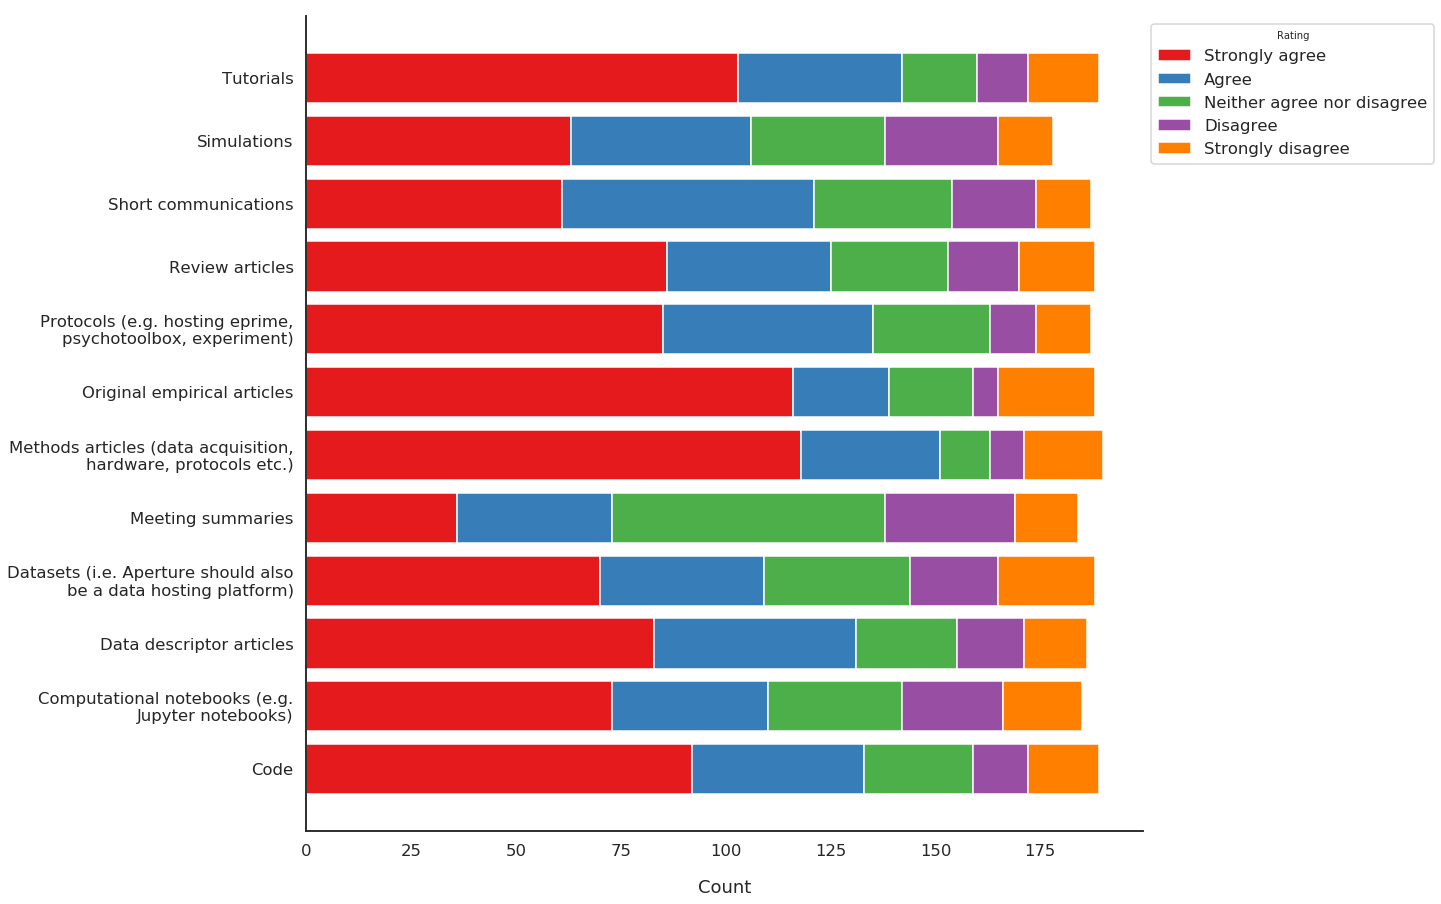

In [8]:
# Next, we'd like to look at want content respondents wanted published in Aperture

content = responses['What content would you like to see in Aperture? \
(1 = would definitely want this, 5 = I would not want this at all)'].apply(pd.to_numeric)
ax = plot_stacked_bar(content, figwidth=15, textwrap=35)
fig = ax.figure
fig.savefig('content.png', dpi=150, bbox_inches='tight')

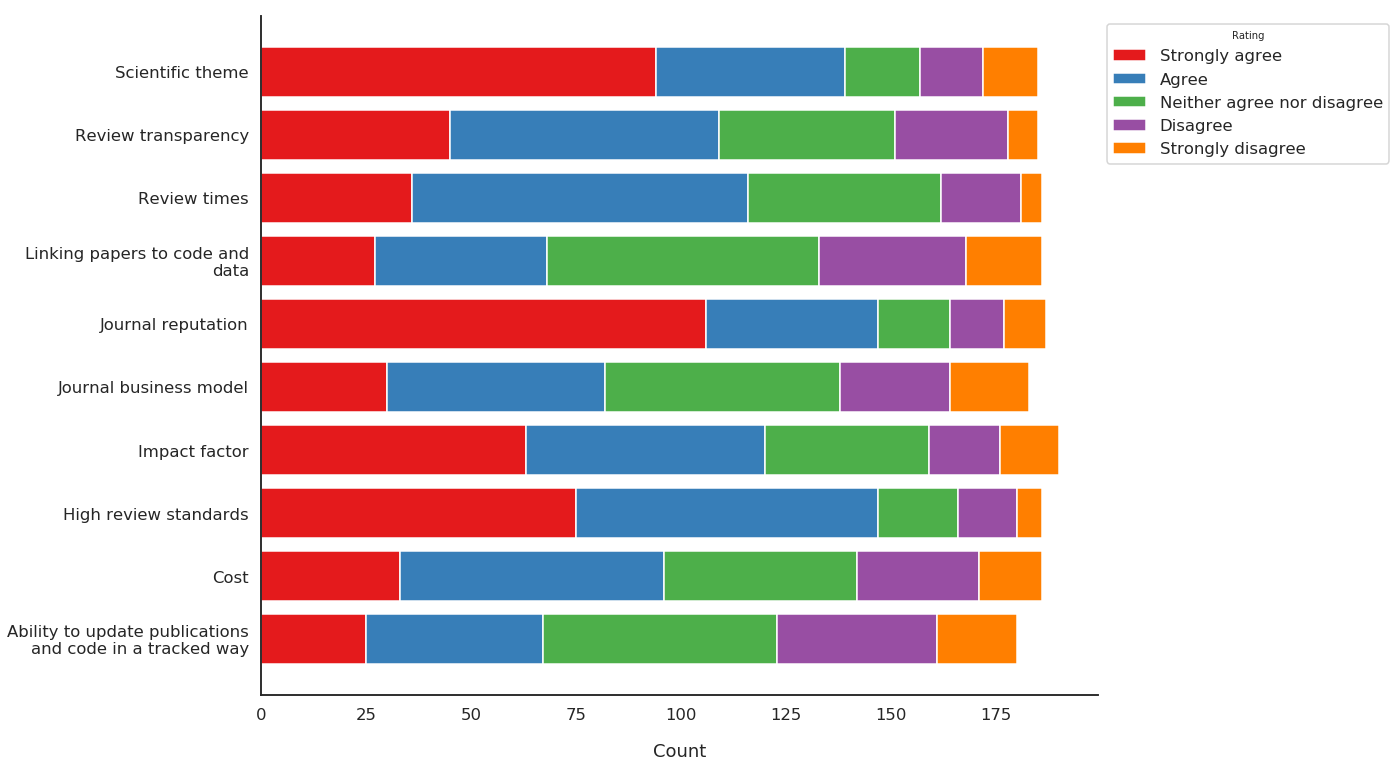

In [9]:
# Next, we'd like to know what factors generally influence where respondents publish.

decision = responses['What factors contribute to your decision where to publish? \
(1 = most important, 5 = least important)'].apply(pd.to_numeric)
ax = plot_stacked_bar(decision)
fig = ax.figure
fig.savefig('publish.png', dpi=150, bbox_inches='tight')

In [10]:
# We can calculate a percentage for how many respondents thought each of the surveyed aspects was important
# when reviewing code.

code = pd.get_dummies(responses['Which of these aspects do you think is important when reviewing code? \
(Check all that apply)'], prefix='', prefix_sep='')
code.sum() / code.count()

Review that code is available and openly accessible                                      0.765625
Review that code can run without error                                                   0.604167
Review that code can reproduce the results in the manuscript                             0.682292
Review code for clarity and adherence with stated software development best practices    0.338542
dtype: float64

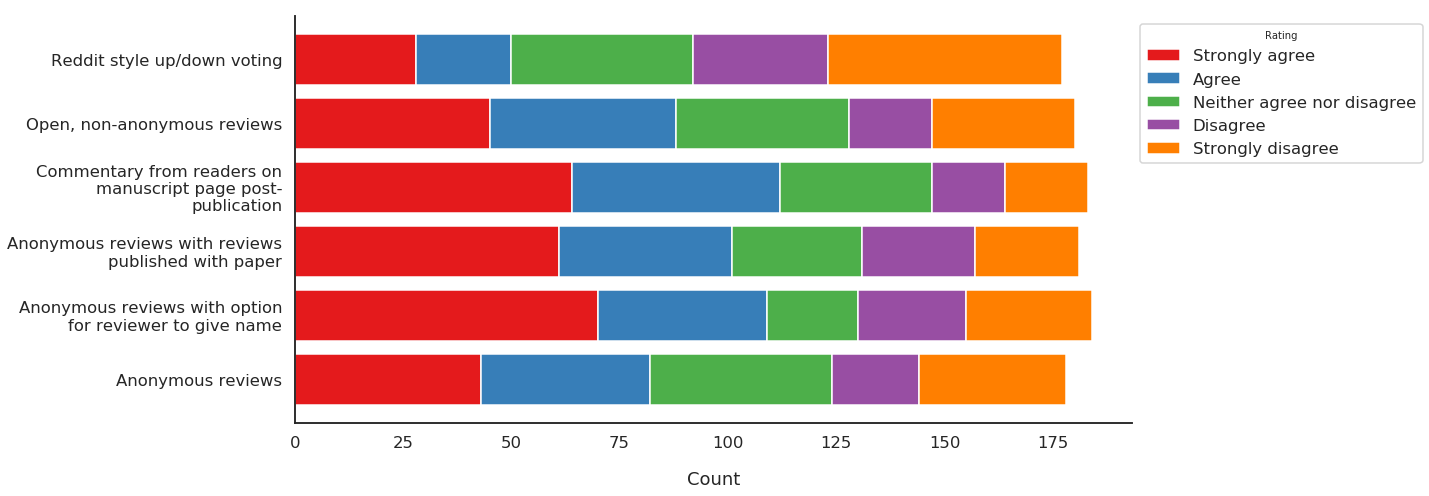

In [11]:
# We'd like to know what reviewing model respondents would like to see available in Aperture.
# For a summary of the different models, see:
# https://authorservices.wiley.com/Reviewers/journal-reviewers/what-is-peer-review/types-of-peer-review.html

model = responses['What reviewer model would you like to see in Aperture? \
(1 = I would definitely want this , 5 = I would not want this at all)'].apply(pd.to_numeric)
ax = plot_stacked_bar(model, figwidth=7.5)
fig = ax.figure
fig.savefig('review.png', dpi=150, bbox_inches='tight')

In [12]:
def percent_agree(option):
    """
    A small function to calculate the number of '1'
    and '2' responses to a given option, indicating
    the number of 'Agree' and 'Strongly Agree' responses.
    These are added and combined to give an overall 'Agree'
    percentage.
    """
    agree = np.count_nonzero(option.values == 1.0)
    agree += np.count_nonzero(option.values == 2.0)
    return agree / len(option.values)

In [13]:
# How do respondents envision Aperture attaining financial sustainability ?
# One way to get at this is to see what models respondents agree with.

sustain = responses['What sustainability model would you prefer? \
(Rank 1 = most desirable, 5 = least desirable)'].apply(pd.to_numeric)

for c in sustain.columns:
    print('{} : {:.2f} % agree'.format(c, percent_agree(sustain[str(c)]) * 100))

Open access: charge for publishing : 46.88 % agree
Open access: separate charge for (1) submitting, and (2) publishing : 32.29 % agree
Open access: no charge for OHBM members to submit, reduced charge for OHBM members to publish, (i.e. charges offset by [increased] OHBM membership fee) : 54.69 % agree
Open access: no submission charge, reduced charge for OHBM members to publish, (i.e. charges offset by [increased] OHBM membership fee) : 51.04 % agree
Paywalled: free to submit/publish; subscription fee for access to publications (reduced for OHBM members) : 27.08 % agree
Paywalled: free to submit/publish; free subscription to OHBM members, but costs covered by increased membership fees : 25.52 % agree


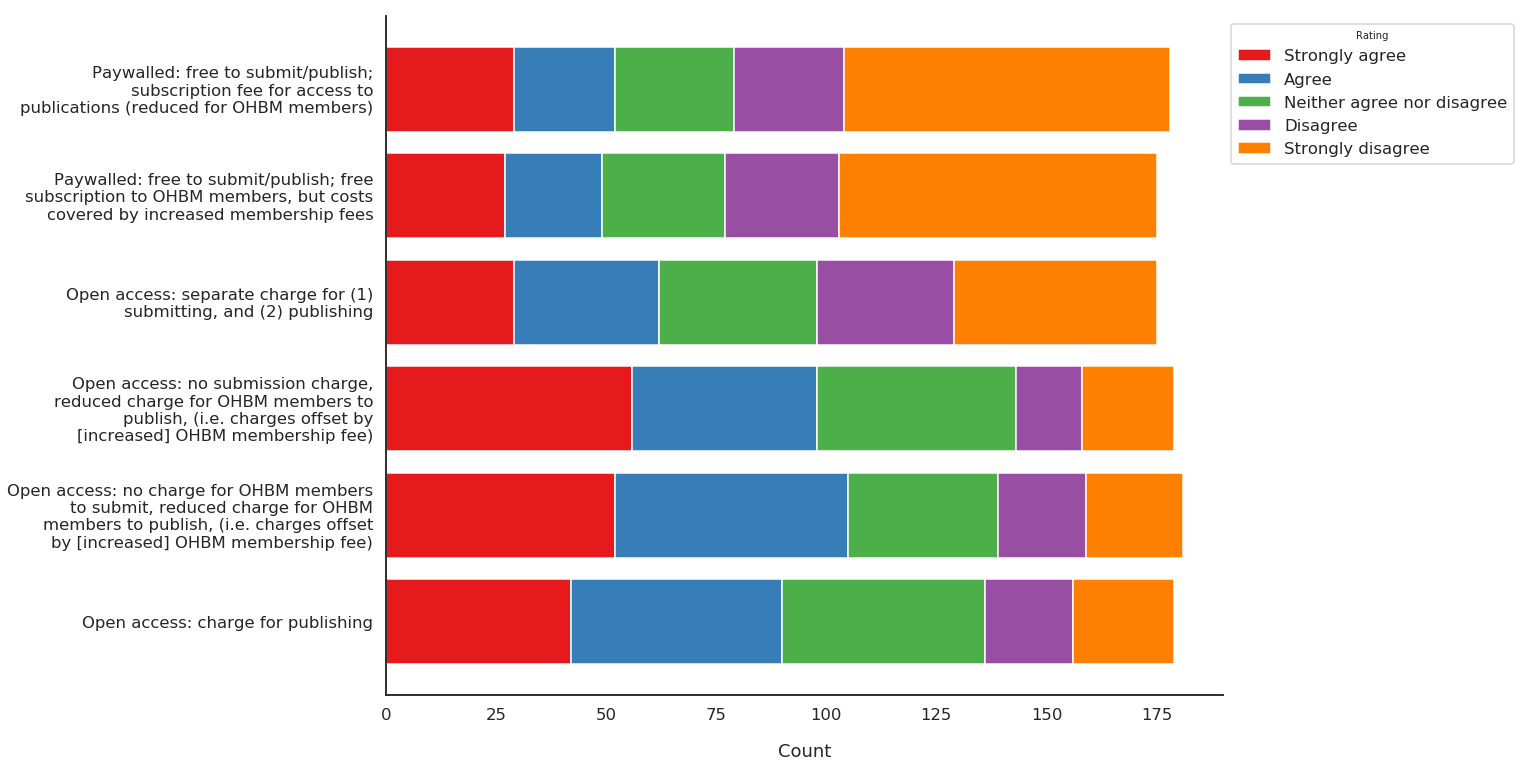

In [14]:
# Let's zoom out and look at the broader distributions of responses for each options

ax = plot_stacked_bar(sustain, textwrap=40)
fig = ax.figure
fig.savefig('sustain.png', dpi=150, bbox_inches='tight')

On average, respondents were willing to pay $50 per submission to Aperture.
They also indicated they would pay an additional $750 to publish in Aperture.


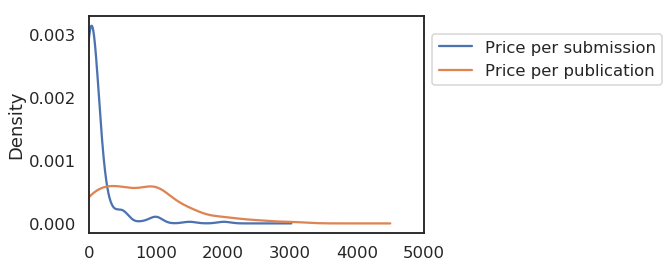

In [15]:
# What are respondents willing to pay to sustain Aperture ?

price_per_sub = pd.to_numeric(responses['Per submission:',
                                        'Open-Ended Response'])
price_per_pub = pd.to_numeric(responses['Per publication:',
                                        'Open-Ended Response'])

# Let's look at the distributions

pd.concat([price_per_sub, price_per_pub], axis=1).plot.kde(xlim=[0, 5000]);
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.8),
           labels=['Price per submission', 'Price per publication']);

# Then we'll print the central tendency for each of these two responses
# Using median since the distributions are skewed

print('On average, respondents were willing to pay ${:.0f} \
per submission to Aperture.'.format(price_per_sub.median()))
print('They also indicated they would pay an additional ${:.0f} \
to publish in Aperture.'.format(price_per_pub.median()))